# Group Project Proposal

Group: 83
<br> Guozheng Gong, Brianna Zhou, Saakshith Manjunath, Hrishikesh Rakeshkumar Dalal

### Title: A Model for the Prediction of Heart Diease

### Introduction:
According to the CDC, heart disease is one of the leading causes of death around the world. The most common risk factors that cause heart disease are vital signs like high blood pressure and cholesterol *(Heart disease and stroke)*. The NIH observed a linear association between a person’s heart rate and heart failure *(Zhang et al.)*. Adults aged 65 and older are more at risk for diseases related to the heart than the youth *(Heart health and aging)*. So we will be looking at these variables to choose the predictors for our data analysis:

- trestbps: resting blood pressure (in mm Hg)
- chol: serum cholesterol (in mg/dl)
- thalach: maximum heart rate achieved in beats each minute (bpm)
- age: age (in years)

Predictive question: Can we use a person’s vital signs to predict whether they have heart disease or not?

We are using a dataset from the UCI Machine Learning Repository. The repository contains four databases about heart disease from four different places: Cleveland, Budapset, California, and Zurich. We will be using the Cleveland version of the database. 



### Preliminary exploratory data analysis:

In [9]:
library(tidyverse) #first run this to load package
library(tidymodels)

In [10]:
download.file(url = "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data", 
              destfile = "data/processed.cleveland.data")
data <- read_csv(file = "data/processed.cleveland.data", 
                 col_names = c("age","sex","cp","trestbps","chol","fbs","restecg","thalach",
                               "exang","oldpeak","slope","ca","thal","num_the_predicted_attribute"))

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): ca, thal
dbl (12): age, sex, cp, trestbps, chol, fbs, restecg, thalach, exang, oldpea...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


According to the data description,  experiments with the Cleveland database have concentrated on simply attempting to distinguish presence (values 1,2,3,4) from absence (value 0). So for this project, values 1,2,3,4 have the same meaning (presence of heart disease), so we are converting the values 2,3,4 in num_the_predicted_attribute to 1. We are also editing the column type to treat these values as factors and not numerical data.

In [11]:
data1 <- filter(data, num_the_predicted_attribute <=1)
data2 <- filter(data, num_the_predicted_attribute > 1)
data2 <- mutate(data2, num_the_predicted_attribute = 1)
data <- merge(data1, data2, all = T)
data <- mutate(data, num_the_predicted_attribute = as_factor(num_the_predicted_attribute))
#change num_the_predicted_attribute to be factor

In [12]:
data <- select(data, age, trestbps ,chol,thalach, num_the_predicted_attribute)#Select the data we need

Now, we are splitting our data set into training and tsting data. We are using 75% of the data as training data.

In [13]:
data_split <- initial_split(data, prop = 0.75, strata = num_the_predicted_attribute) #split training data
data_train <- training(data_split)   
data_test <- testing(data_split)

Using group_by + summarize to compute the mean of each of the columns for every possible predicted variable (i.e., 0 = absence of heart disease, 1 = presence of heart disease):

In [18]:
summary_data <- group_by(data_train,num_the_predicted_attribute) |>
    summarize(trestbps_mean = mean(trestbps), 
              chol_mean = mean(chol),
              age_mean = mean(age),
              thalach_mean=mean(thalach), n=n())
summary_data

num_the_predicted_attribute,trestbps_mean,chol_mean,age_mean,thalach_mean,n
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
0,130.0163,242.3415,53.13821,158.8049,123
1,134.3846,254.3846,56.40385,139.9038,104


Counting the missing data in each column:

In [19]:
missing_data <- data %>%
    map_df(is.na) %>%
    map_df(sum)
missing_data

age,trestbps,chol,thalach,num_the_predicted_attribute
<int>,<int>,<int>,<int>,<int>
0,0,0,0,0


It looks like there is no missing data.

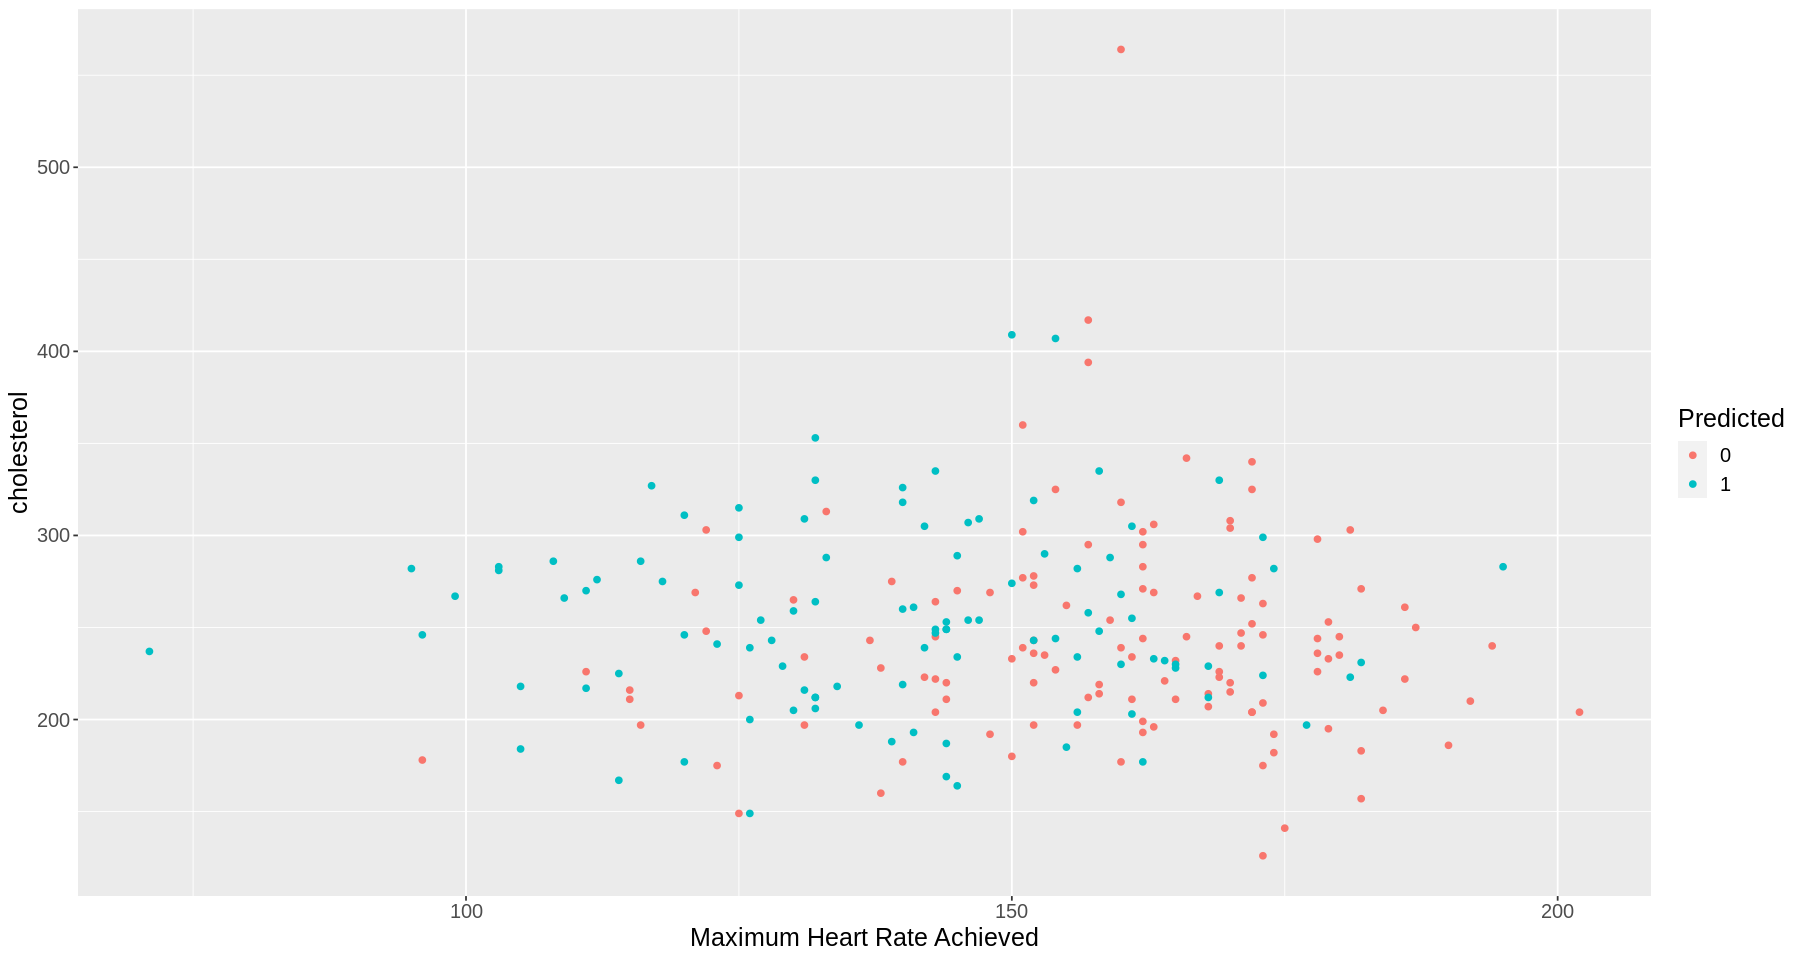

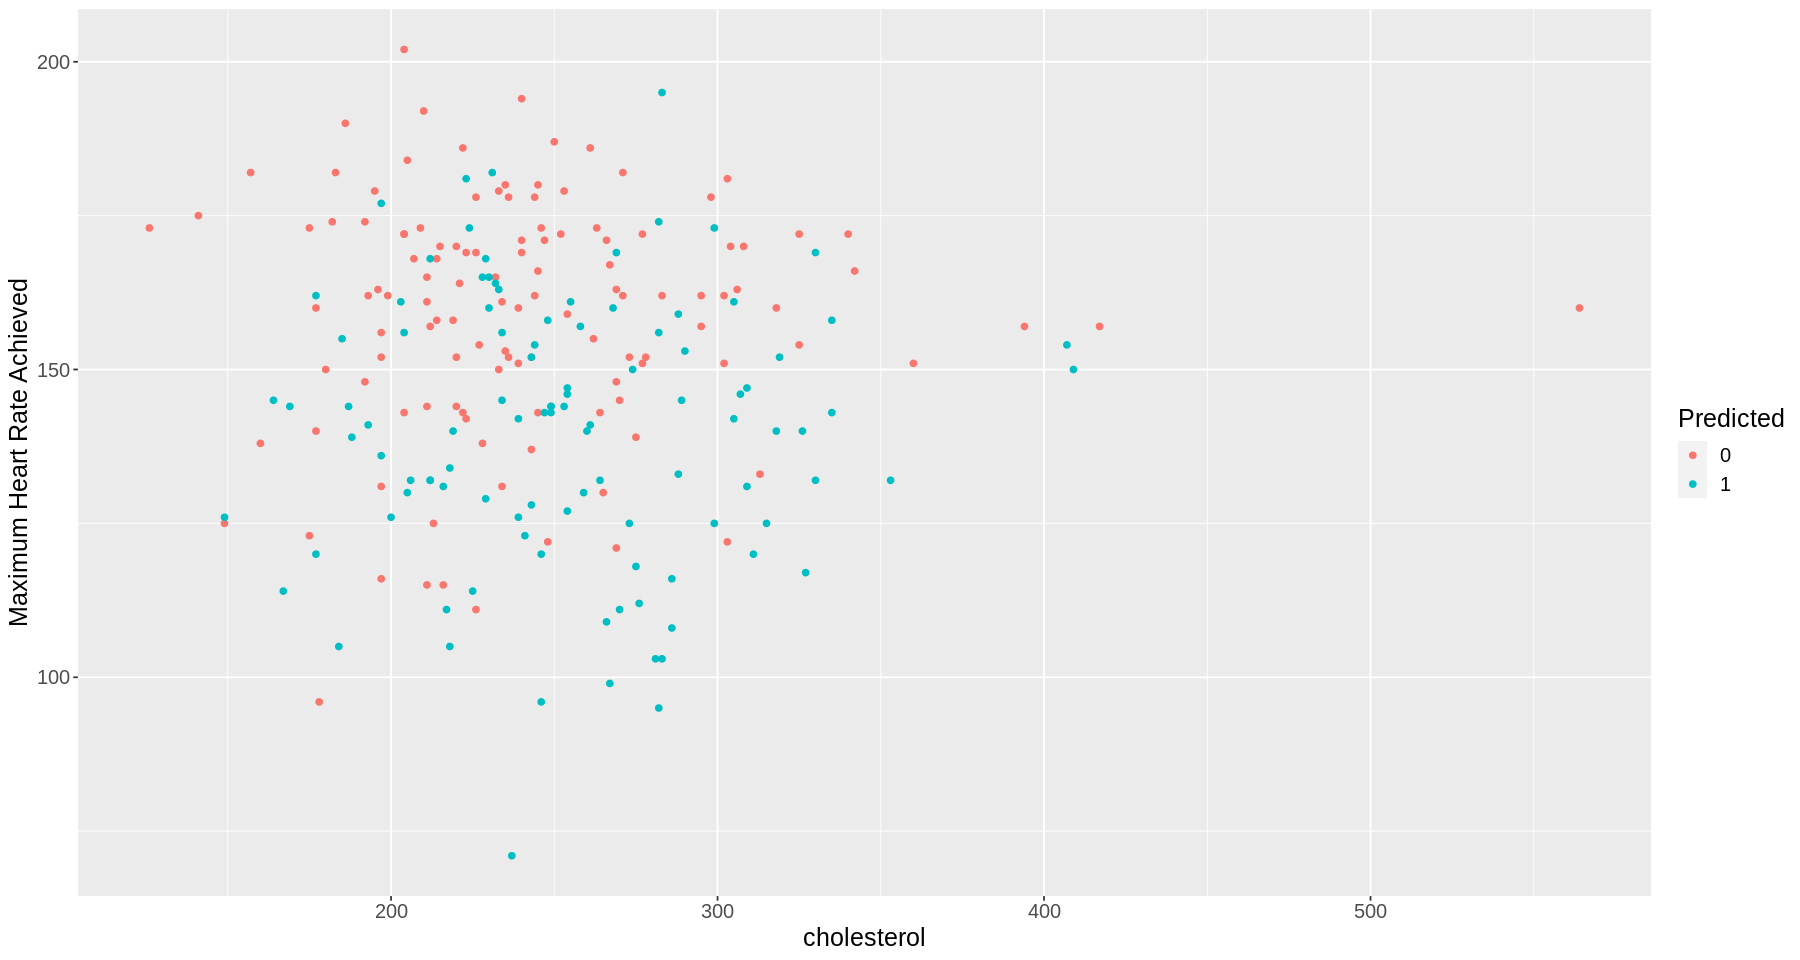

In [21]:
options(repr.plot.width = 15, repr.plot.height = 8) 

chol_v_hr_plot <- data_train |>
ggplot(aes(x = thalach, y = chol, colour = num_the_predicted_attribute)) +
geom_point() +
labs(x = "Maximum Heart Rate Achieved", y = "cholesterol", colour = "Predicted") +
theme(text=element_text(size=15))

chol_v_hr_plot



From the scatterplot, there does seem to be any relationship between the two variables, Cholesterol and Maximum Heart Rate Achieved. However, we can observe that the most of the red points lie between 150-200 and the blue points are more 

### Methods:
- Explain how you will conduct either your data analysis and which variables/columns you will use. Note - you do not need to use all variables/columns that exist in the raw data set. In fact, that's often not a good idea. For each variable think: is this a useful variable for prediction?
- Describe at least one way that you will visualize the results

### Expected outcomes and significance:
- What do you expect to find?
- What impact could such findings have?
- What future questions could this lead to?